In [1]:
##vocab production script
#imports
import multiprocessing
from multiprocessing import Pool
import math, random, sys
import pickle
import argparse
from functools import partial
import torch
import numpy
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from hgraph import MolGraph, common_atom_vocab, PairVocab
import rdkit
import rdkit.Chem as Chem
import networkx as nx
from hgraph.chemutils import *
from hgraph.nnutils import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG
import time
from rdkit.Chem import Draw
import itertools
from collections import Counter

# IPythonConsole.drawOptions.addAtomIndices = True
# IPythonConsole.molSize = 300,300

#test: this change should only appear in the 'peptide' branch

/home/marcase/.conda/envs/hgraph-rdkit/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [118]:
# peptide = 'OC(C[C@@H](C(N[C@H](C(N[C@H](C(N[C@H](C(NCC(N[C@H](C(N[C@@]([H])([C@@H](C)CC)C(N[C@@H](CC(C)C)C(N[C@H](C(N[C@H](C(N[C@@H](CC1=CC=CC=C1)C(N2CCC[C@H]2C(N[C@H](C(N[C@@]([C@H](O)C)(C(N[C@H](C(N[C@H](C(N[C@H](C(N[C@H](C(N[C@H](C(O)=O)CSC3)=O)CSCC3=O)=O)C(C)C)=O)CC4=CC=C(O)C=C4)=O)CC5=CNC6=C5C=CC=C6)=O)[H])=O)CO)=O)=O)=O)CCSC)=O)CCCCN[H])=O)=O)=O)CC7=CNC=N7)=O)=O)CCC(N)=O)=O)CCC(O)=O)=O)CS[H])=O)NC([C@@H](NC([C@@H](NC([C@H](C)NC(CN)=O)=O)CCCNC(N)=N)=O)CC(N)=O)=O)=O'
#c term proline
# peptide = 'N[C@@H]([C@]([H])(O)C)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](C(C)C)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CCC(=O)O)C(=O)N[C@@H](CC1=CN=C-N1)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CO)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CS3)C(=O)N1[C@@H](CCC1)C(=O)O'
#n term proline
peptide = 'N1[C@@H](CCC1)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](CS3)C(=O)N[C@@H](C)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CC(=CN2)C1=C2C=CC=C1)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CCCNC(=N)N)C(=O)O'
#random peptides
# peptide = 'N[C@@H]([H])C(=O)N[C@@H](CSCC(C4)=O)C(=O)N1[C@@H](CCC1)C(=O)N[C@@H](CCC(=O)N)C(=O)N[C@@H](CS3)C(=O)N[C@@H](CC(=O)O)C(=O)N[C@@H](C(C)C)C(=O)N[C@@H](CSCC(C3)=O)C(=O)N[C@@H](Cc1ccc(O)cc1)C(=O)N[C@@H](CCCNC(=N)N)C(=O)N[C@@H](CS4)C(=O)N1[C@@H](CCC1)C(=O)O'

peptide = get_mol(peptide)

In [119]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

mol_with_atom_index(peptide)

Draw.MolToFile(peptide, "peptide.png",size=(6000,6000))

In [120]:
#separately define proline, because the backbone creates double recognition
proline = 'O=CC1CCCN1'
proline_matches = peptide.GetSubstructMatches(Chem.MolFromSmiles(proline),useChirality=True)
proline_matches

((6, 5, 1, 2, 3, 4, 0), (55, 54, 50, 51, 52, 53, 49))

In [121]:
#find all amino acids
amino_acid_motif = 'NCC=O'
matches = peptide.GetSubstructMatches(Chem.MolFromSmiles(amino_acid_motif),useChirality=True)
matches

((0, 1, 5, 6),
 (7, 8, 15, 16),
 (17, 18, 21, 22),
 (23, 24, 26, 27),
 (28, 29, 37, 38),
 (39, 40, 47, 48),
 (49, 50, 54, 55),
 (56, 57, 68, 69),
 (70, 71, 76, 77),
 (78, 79, 84, 85),
 (86, 87, 90, 91),
 (92, 93, 101, 102))

In [122]:
#find matches that aren't prolines
matches_without_prolines = [match for match in matches if not any([x in np.hstack(proline_matches) for x in match])]
matches_without_prolines

[(7, 8, 15, 16),
 (17, 18, 21, 22),
 (23, 24, 26, 27),
 (28, 29, 37, 38),
 (39, 40, 47, 48),
 (56, 57, 68, 69),
 (70, 71, 76, 77),
 (78, 79, 84, 85),
 (86, 87, 90, 91),
 (92, 93, 101, 102)]

In [123]:
#get matches with overlapping nitrogens for cluster identification (this method will not get the C-terminal amino acid)
amino_acid_n = 'NCC(=O)N'
matches_n = peptide.GetSubstructMatches(Chem.MolFromSmiles(amino_acid_n),useChirality=True)
matches_n_no_prolines = [match for match in matches_n if sum([x in np.hstack(proline_matches) for x in match]) < 2]
matches_n = [match_n for match_n in matches_n]
matches_n

[(0, 1, 5, 6, 7),
 (7, 8, 15, 16, 17),
 (17, 18, 21, 22, 23),
 (23, 24, 26, 27, 28),
 (28, 29, 37, 38, 39),
 (39, 40, 47, 48, 49),
 (49, 50, 54, 55, 56),
 (56, 57, 68, 69, 70),
 (70, 71, 76, 77, 78),
 (78, 79, 84, 85, 86),
 (86, 87, 90, 91, 92)]

In [124]:
#get matches with overlapping carboynl oxygens for cluster identification (this method will not get the N-terminal amino acid)
amino_acid_c = 'O=CCNC'
matches_c = peptide.GetSubstructMatches(Chem.MolFromSmiles(amino_acid_c),useChirality=True)
matches_c_no_prolines = [match for match in matches_c if sum([x in np.hstack(proline_matches) for x in match]) < 2]
matches_c

((6, 5, 1, 0, 4),
 (16, 15, 8, 7, 5),
 (22, 21, 18, 17, 15),
 (27, 26, 24, 23, 21),
 (38, 37, 29, 28, 26),
 (48, 47, 40, 39, 37),
 (55, 54, 50, 49, 47),
 (55, 54, 50, 49, 53),
 (69, 68, 57, 56, 54),
 (77, 76, 71, 70, 68),
 (85, 84, 79, 78, 76),
 (91, 90, 87, 86, 84),
 (102, 101, 93, 92, 90))

In [125]:
#split up side chain atoms and backbone atoms
backbone_atoms = np.hstack(np.unique(np.concatenate((np.hstack(matches_n_no_prolines),np.hstack(matches_c_no_prolines),np.hstack(proline_matches),np.hstack(peptide.GetSubstructMatches(Chem.MolFromSmiles('NCC(O)=O'),useChirality=True))))))
sidechain_atoms = np.setdiff1d(np.array(range(1,peptide.GetNumAtoms())),backbone_atoms)
backbone_atoms
# sidechain_atoms

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,  15,  16,  17,  18,
        21,  22,  23,  24,  26,  27,  28,  29,  37,  38,  39,  40,  47,
        48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  68,  69,  70,
        71,  76,  77,  78,  79,  84,  85,  86,  87,  90,  91,  92,  93,
       101, 102, 103])

In [126]:
matches_double_overlap = peptide.GetSubstructMatches(Chem.MolFromSmiles('NCC(NCC=O)=O'),useChirality=True)
matches_double_overlap = [m for m in matches_double_overlap if not any([x in sidechain_atoms for x in m])]
count = Counter(np.hstack(matches_double_overlap))
matches_double_overlap = [m for m in matches_double_overlap if not all(count[x] > 1 for x in m )]
if len(matches_double_overlap) == 2:
    n_terminus = [x for x in matches_double_overlap[0] if count[x] == 1]
    c_terminus = [x for x in matches_double_overlap[1] if count[x] == 1]
else:
    print('could not identify termini correctly')

In [127]:
#identify the termini clusters
#nterm cluster
if any([x in np.hstack(proline_matches) for x in n_terminus]): #n_terminus is a proline
    n_terminus = [np.array(proline) for proline in proline_matches if any([x in n_terminus for x in proline])][0]
else: #n_terminus is not a proline
    n_terminus = [np.array(match) for match in matches if any([x in n_terminus for x in match])][0]
n_terminus


array([6, 5, 1, 2, 3, 4, 0])

In [128]:
#cterm cluster
if any([x in np.hstack(proline_matches) for x in c_terminus]):
    c_terminus = np.array(peptide.GetSubstructMatches(Chem.MolFromSmiles('CN1[C@H](C(O)=O)CCC1'),useChirality=True))[0]
else: #c terminus is not a proline
    c_terminus = np.array(peptide.GetSubstructMatches(Chem.MolFromSmiles('CNCC(=O)O'),useChirality=True))[0]
c_terminus

array([ 90,  92,  93, 101, 102, 103])

In [129]:
#non-terminus prolines
prolines_non_terminal = [proline for proline in proline_matches if not any([(x in c_terminus) or (x in n_terminus) for x in proline])]
if len(prolines_non_terminal) > 0:
    prolines_not_terminal_overlap = peptide.GetSubstructMatches(Chem.MolFromSmiles('O=CC1CCCN1C'),useChirality=True)
    prolines_not_terminal_overlap = [proline for proline in prolines_not_terminal_overlap if any([x in np.hstack(prolines_non_terminal) for x in proline])]
else:
    prolines_not_terminal_overlap = []
prolines_not_terminal_overlap

[(55, 54, 50, 51, 52, 53, 49, 47)]

In [130]:
clusters = list()
[clusters.append(match) for match in matches_c_no_prolines if sum([x in c_terminus for x in match]) < 2]
clusters.append(list(c_terminus))
clusters.append(list(n_terminus))
[clusters.append(proline) for proline in prolines_not_terminal_overlap]
clusters

[(16, 15, 8, 7, 5),
 (22, 21, 18, 17, 15),
 (27, 26, 24, 23, 21),
 (38, 37, 29, 28, 26),
 (48, 47, 40, 39, 37),
 (69, 68, 57, 56, 54),
 (77, 76, 71, 70, 68),
 (85, 84, 79, 78, 76),
 (91, 90, 87, 86, 84),
 [90, 92, 93, 101, 102, 103],
 [6, 5, 1, 2, 3, 4, 0],
 (55, 54, 50, 51, 52, 53, 49, 47)]

In [131]:
c_alphas = np.array(matches)[:,1]
c_alphas_neighbors = [peptide.GetAtomWithIdx(int(x)).GetNeighbors() for x in c_alphas]
sidechain_atoms_with_calphas = np.union1d(sidechain_atoms,c_alphas)
# sidechain_atoms_with_calphas
backbone_atoms_without_calphas = np.setdiff1d(backbone_atoms,c_alphas)
# backbone_atoms_without_calphas
c_alphas

array([ 1,  8, 18, 24, 29, 40, 50, 57, 71, 79, 87, 93])

In [132]:
##recursively identify alpha carbons, and map the atom indices that contain their side chains


for index,c_alpha in enumerate(c_alphas):
    c_alpha_neighbors = peptide.GetAtomWithIdx(int(c_alpha)).GetNeighbors()
    print('starting c_alpha atom index: ' + str(c_alpha))
    # print('neighbor indices: ' +str([neighbor.GetIdx() for neighbor in c_alpha_neighbors]))
    # print('neighbor atomic masses: ' + str([neighbor.GetAtomicNum() for neighbor in c_alpha_neighbors]))
    # print('starting atoms: ' + str([c_alpha_neighbor.GetIdx() for c_alpha_neighbor in c_alpha_neighbors]))
    # if c_alpha in c_terminus:
    #     print('c terminus skipped: ' + str(c_alpha))
    #     continue
    if c_alpha in np.hstack(proline_matches):
        print('skipped proline')
        continue
    for neighbor in c_alpha_neighbors:
        if (neighbor.GetIdx() not in backbone_atoms) and (neighbor.GetAtomicNum() == 6):
            # print('starting side chain atom: '+str(neighbor.GetIdx()) + ', atomic num: ' + str(neighbor.GetAtomicNum()))
            side_chain_atoms = np.array([neighbor.GetIdx()])
            new_neighbors = neighbor.GetNeighbors()
            # print('starting neighbor atom(s): ' + str([new_neighbor.GetIdx() for new_neighbor in new_neighbors]) + ', atomic num(s): ' + str([new_neighbor.GetAtomicNum() for new_neighbor in new_neighbors]))
            atoms_to_examine = np.array([])
            while(len(new_neighbors) > 0):
                for new_neighbor in new_neighbors:
                    if (new_neighbor.GetIdx() in c_alphas) and (new_neighbor.GetIdx() not in sidechain_atoms):
                        print('new stapled residue c_alpha atom found, index: ' + str(new_neighbor.GetIdx()))
                        side_chain_atoms = np.append(side_chain_atoms,new_neighbor.GetIdx())
                    elif (new_neighbor.GetIdx() not in side_chain_atoms) and (new_neighbor.GetIdx() not in backbone_atoms):
                        # print('new neighbor atom found, index: ' + str(new_neighbor.GetIdx()))
                        side_chain_atoms = np.append(side_chain_atoms,new_neighbor.GetIdx())
                        # print('side_chain_atom(s): ' + str(side_chain_atoms))
                        atoms_to_examine = np.append(atoms_to_examine,new_neighbor.GetIdx())
                        # print('atom(s) to examine: ' + str(atoms_to_examine))
                    elif new_neighbor.GetIdx()  in side_chain_atoms:
                        # print('already found this atom in side chain: ' + str(new_neighbor.GetIdx()))
                        continue
                    elif new_neighbor.GetIdx() in backbone_atoms:
                        # print('already found this atom in back bone: ' + str(new_neighbor.GetIdx()))
                        continue
                if len(atoms_to_examine) == 0:
                    # print('no new atoms to explore')
                    break
                else:
                    new_neighbors = np.hstack([peptide.GetAtomWithIdx(int(atom)).GetNeighbors() for atom in atoms_to_examine])
                    # print('new neighbors to investigate: ' + str([new_neighbor.GetIdx() for new_neighbor in new_neighbors]))
                    atoms_to_examine = np.array([])
            print('complete mapped side chain: ' + str([x for x in side_chain_atoms]))
            if sum([x in np.hstack(clusters) for x in side_chain_atoms]) < 3:
                clusters.append(np.array([x for x in side_chain_atoms]))
            # if not any([x in np.hstack(clusters) for x in side_chain_atoms]):
            #     clusters.append(np.concatenate([np.array([x for x in side_chain_atoms]),np.array([c_alpha])]))
            
    #neighbors are not in a consistent order

clusters
# [peptide.GetAtomWithIdx(x).GetNeighbors() for x in c_alphas]

starting c_alpha atom index: 1
skipped proline
starting c_alpha atom index: 8
new stapled residue c_alpha atom found, index: 8
new stapled residue c_alpha atom found, index: 18
complete mapped side chain: [9, 8, 10, 11, 12, 13, 14, 20, 19, 18]
starting c_alpha atom index: 18
new stapled residue c_alpha atom found, index: 18
new stapled residue c_alpha atom found, index: 8
complete mapped side chain: [19, 18, 20, 13, 12, 11, 14, 10, 9, 8]
starting c_alpha atom index: 24
new stapled residue c_alpha atom found, index: 24
complete mapped side chain: [25, 24]
starting c_alpha atom index: 29
new stapled residue c_alpha atom found, index: 29
complete mapped side chain: [30, 29, 31, 32, 33, 34, 35, 36]
starting c_alpha atom index: 40
new stapled residue c_alpha atom found, index: 40
new stapled residue c_alpha atom found, index: 87
complete mapped side chain: [41, 40, 42, 43, 44, 45, 46, 89, 88, 87]
starting c_alpha atom index: 50
skipped proline
starting c_alpha atom index: 57
new stapled res

[(16, 15, 8, 7, 5),
 (22, 21, 18, 17, 15),
 (27, 26, 24, 23, 21),
 (38, 37, 29, 28, 26),
 (48, 47, 40, 39, 37),
 (69, 68, 57, 56, 54),
 (77, 76, 71, 70, 68),
 (85, 84, 79, 78, 76),
 (91, 90, 87, 86, 84),
 [90, 92, 93, 101, 102, 103],
 [6, 5, 1, 2, 3, 4, 0],
 (55, 54, 50, 51, 52, 53, 49, 47),
 array([ 9,  8, 10, 11, 12, 13, 14, 20, 19, 18]),
 array([25, 24]),
 array([30, 29, 31, 32, 33, 34, 35, 36]),
 array([41, 40, 42, 43, 44, 45, 46, 89, 88, 87]),
 array([58, 57, 59, 60, 62, 61, 63, 67, 64, 66, 65]),
 array([72, 71, 73, 74, 75]),
 array([80, 79, 81, 82, 83]),
 array([ 94,  93,  95,  96,  97,  98,  99, 100])]

In [133]:
#get atom_cls
atom_cls = [[] for i in range(len(peptide.GetAtoms()))]
for i in range(len(clusters)):
    for atom in clusters[i]:
        atom_cls[atom].append(i)
atom_cls

[[10],
 [10],
 [10],
 [10],
 [10],
 [0, 10],
 [10],
 [0],
 [0, 12],
 [12],
 [12],
 [12],
 [12],
 [12],
 [12],
 [0, 1],
 [0],
 [1],
 [1, 12],
 [12],
 [12],
 [1, 2],
 [1],
 [2],
 [2, 13],
 [13],
 [2, 3],
 [2],
 [3],
 [3, 14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [3, 4],
 [3],
 [4],
 [4, 15],
 [15],
 [15],
 [15],
 [15],
 [15],
 [15],
 [4, 11],
 [4],
 [11],
 [11],
 [11],
 [11],
 [11],
 [5, 11],
 [11],
 [5],
 [5, 16],
 [16],
 [16],
 [16],
 [16],
 [16],
 [16],
 [16],
 [16],
 [16],
 [16],
 [5, 6],
 [5],
 [6],
 [6, 17],
 [17],
 [17],
 [17],
 [17],
 [6, 7],
 [6],
 [7],
 [7, 18],
 [18],
 [18],
 [18],
 [18],
 [7, 8],
 [7],
 [8],
 [8, 15],
 [15],
 [15],
 [8, 9],
 [8],
 [9],
 [9, 19],
 [19],
 [19],
 [19],
 [19],
 [19],
 [19],
 [19],
 [9],
 [9],
 [9]]

In [134]:
graph = nx.empty_graph( len(clusters) )
for atom, nei_cls in enumerate(atom_cls):
    if len(nei_cls) <= 1: continue
    bonds = [c for c in nei_cls if len(clusters[c]) == 2]
    rings = [c for c in nei_cls if len(clusters[c]) > 4] #need to change to 2

    if len(nei_cls) > 2 and len(bonds) >= 2:
        clusters.append([atom])
        c2 = len(clusters) - 1
        graph.add_node(c2)
        for c1 in nei_cls:
            graph.add_edge(c1, c2, weight = 100)

    elif len(rings) > 2: #Bee Hives, len(nei_cls) > 2 
        clusters.append([atom]) #temporary value, need to change
        c2 = len(clusters) - 1
        graph.add_node(c2)
        for c1 in nei_cls:
            graph.add_edge(c1, c2, weight = 100)
    else:
        for i,c1 in enumerate(nei_cls):
            for c2 in nei_cls[i + 1:]:
                inter = set(clusters[c1]) & set(clusters[c2])
                graph.add_edge(c1, c2, weight = len(inter))

n, m = len(graph.nodes), len(graph.edges)

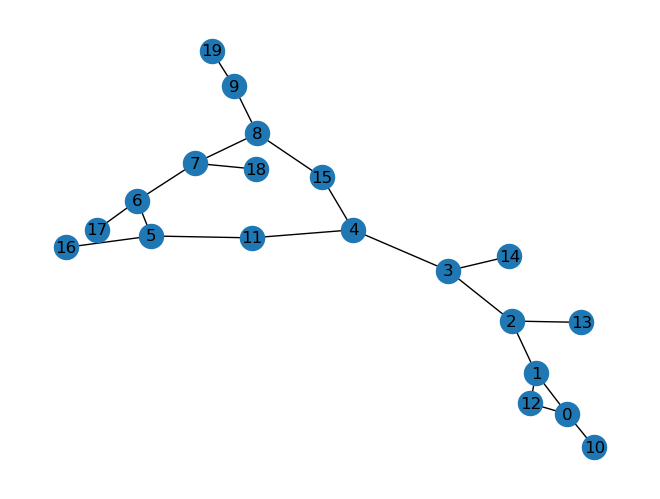

In [135]:
nx.draw(graph,with_labels=True)
plt.show()

In [136]:
n-m

-1